In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/Affordable_Housing_Cleaned.csv")
print(f"Shape: {df.shape}")
display(df.head())

Shape: (2197, 13)


,Year,Town Code,Town,Census Units,Government Assisted,Tenant Rental Assistance,Single Family CHFA/ USDA Mortgages,Deed Restricted Units,Total Assisted Units,Percent Affordable,Town_Encoded,Calculated_Pct,Period
0,2023,1,Andover,1324,24,1,26,0,51,3.85,0,3.85,2020-2023
1,2022,1,Andover,1317,24,1,27,0,52,3.95,0,3.95,2020-2023
2,2021,1,Andover,1317,24,1,29,0,54,4.10,0,4.10,2020-2023
3,2020,1,Andover,1317,18,1,32,0,51,3.87,0,3.87,2020-2023
4,2019,1,Andover,1317,18,1,29,0,48,3.64,0,3.64,2016-2019


In [3]:
# Target: Percent Affordable
# Features: housing unit type columns + Census Units + Year
features = ['Census Units', 'Government Assisted', 'Tenant Rental Assistance',
            'Single Family CHFA/ USDA Mortgages', 'Deed Restricted Units', 'Year']
target = 'Percent Affordable'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

print(f"Features: {features}")
print(f"Target: {target}")
print(f"Samples: {len(df_model)}")

Features: ['Census Units', 'Government Assisted', 'Tenant Rental Assistance', 'Single Family CHFA/ USDA Mortgages', 'Deed Restricted Units', 'Year']
Target: Percent Affordable
Samples: 2197


In [4]:
# TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {X_train.shape[0]}")
print(f"Test size:  {X_test.shape[0]}")


Train size: 1757
Test size:  440


In [5]:
# FEATURE SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [6]:
# MODEL TRAINING

model = LinearRegression()
model.fit(X_train_scaled, y_train)
print("Model trained successfully.")

# Coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
coef_df = coef_df.sort_values('Coefficient', ascending=False)
print(f"Intercept: {model.intercept_:.4f}")
display(coef_df)

Model trained successfully.
Intercept: 6.1894


,Feature,Coefficient
1,Government Assisted,7.051865
3,Single Family CHFA/ USDA Mortgages,2.621082
5,Year,0.120786
4,Deed Restricted Units,-0.149011
0,Census Units,-1.330399
2,Tenant Rental Assistance,-2.976416


In [7]:
# MODEL EVALUATION

y_pred = model.predict(X_test_scaled)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"MSE:       {mse:.4f}")
print(f"RMSE:      {rmse:.4f}")


# Cross-Validation
cv_scores = cross_val_score(model, scaler.fit_transform(X), y, cv=5, scoring='r2')
print(f"5-Fold CV R² Scores: {cv_scores.round(4)}")
print(f"Mean CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

R² Score:  0.7289
MAE:       2.1136
MSE:       9.6128
RMSE:      3.1004
5-Fold CV R² Scores: [0.533  0.8939 0.8642 0.6813 0.4495]
Mean CV R²: 0.6844 ± 0.1757


#### VISUALIZATIONS

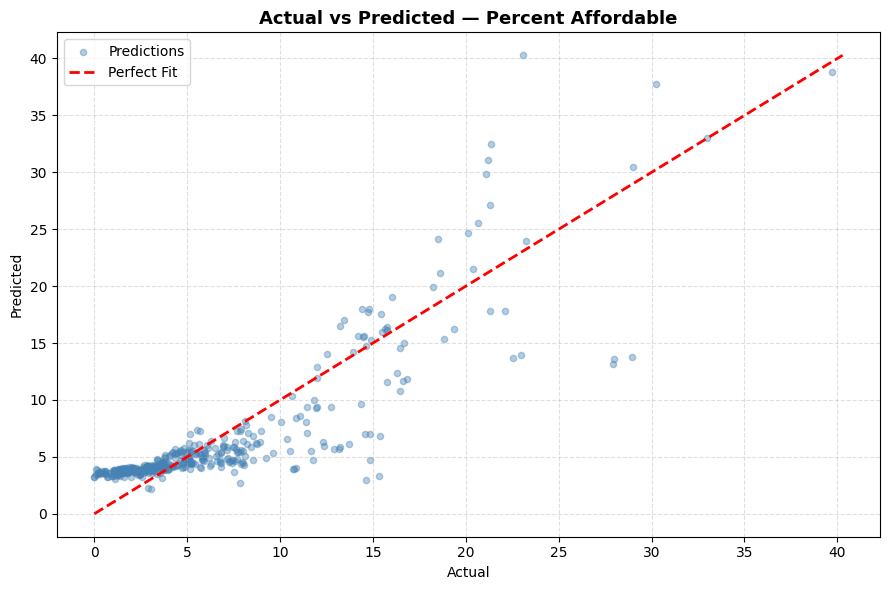

In [10]:
# 5.6.1 Actual vs Predicted
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(y_test, y_pred, alpha=0.4, color='steelblue', s=20, label='Predictions')
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linewidth=2, linestyle='--', label='Perfect Fit')
ax.set_title("Actual vs Predicted — Percent Affordable", fontsize=13, fontweight='bold')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.legend()
ax.grid(linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("../data/5_actual_vs_predicted.png", dpi=150, bbox_inches='tight')
plt.show()

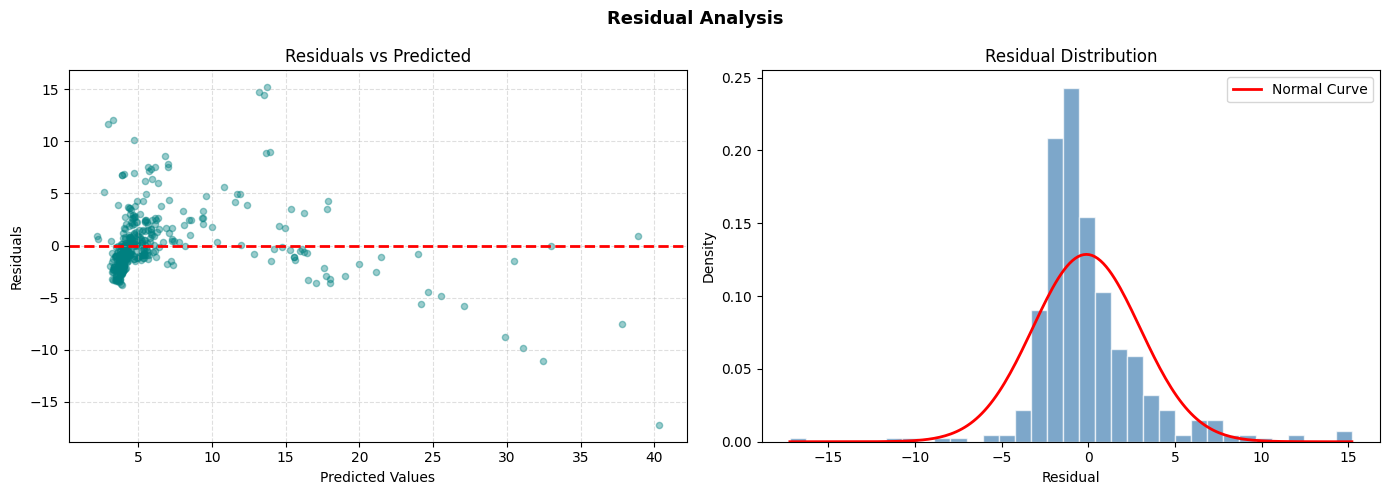

In [11]:
# Residual Plot
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Residual Analysis", fontsize=13, fontweight='bold')

axes[0].scatter(y_pred, residuals, alpha=0.4, color='teal', s=20)
axes[0].axhline(0, color='red', linewidth=2, linestyle='--')
axes[0].set_title("Residuals vs Predicted")
axes[0].set_xlabel("Predicted Values")
axes[0].set_ylabel("Residuals")
axes[0].grid(linestyle='--', alpha=0.4)

axes[1].hist(residuals, bins=35, color='steelblue', edgecolor='white', density=True, alpha=0.7)
mu_r, std_r = residuals.mean(), residuals.std()
x_r = np.linspace(residuals.min(), residuals.max(), 200)
axes[1].plot(x_r, stats.norm.pdf(x_r, mu_r, std_r), color='red', linewidth=2, label='Normal Curve')
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.savefig("../data/5_residuals.png", dpi=150, bbox_inches='tight')
plt.show()

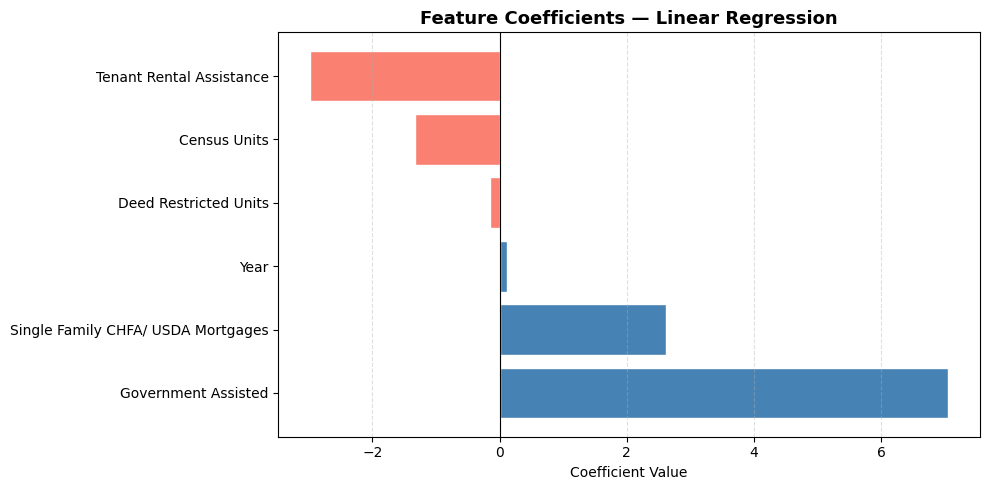

In [12]:
# Feature Coefficients Bar Chart
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['steelblue' if c >= 0 else 'salmon' for c in coef_df['Coefficient']]
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='white')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title("Feature Coefficients — Linear Regression", fontsize=13, fontweight='bold')
ax.set_xlabel("Coefficient Value")
ax.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("../data/5_coefficients.png", dpi=150, bbox_inches='tight')
plt.show()

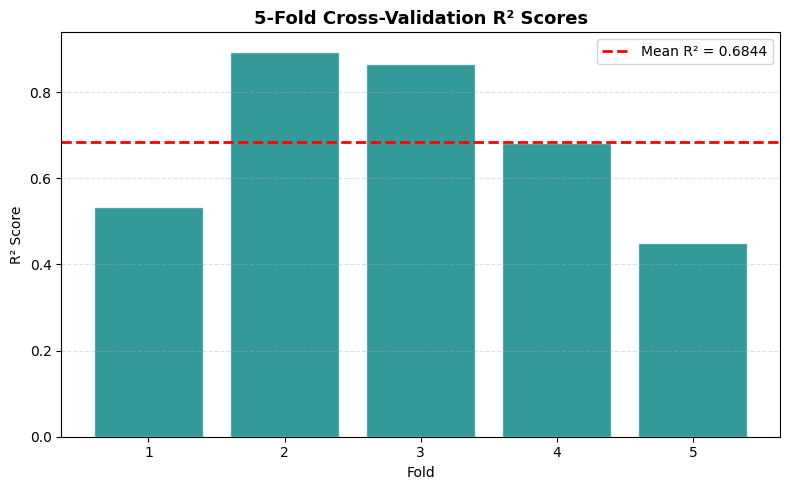

In [13]:
# Cross-Validation Scores
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(1, 6), cv_scores, color='teal', edgecolor='white', alpha=0.8)
ax.axhline(cv_scores.mean(), color='red', linewidth=2, linestyle='--', label=f'Mean R² = {cv_scores.mean():.4f}')
ax.set_title("5-Fold Cross-Validation R² Scores", fontsize=13, fontweight='bold')
ax.set_xlabel("Fold")
ax.set_ylabel("R² Score")
ax.set_xticks(range(1, 6))
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("../data/5_cv_scores.png", dpi=150, bbox_inches='tight')
plt.show()


In [14]:
# HYPOTHESIS TEST ON REGRESSION

# t-test: Are residuals normally distributed (mean ≈ 0)?
t_stat, p_val = stats.ttest_1samp(residuals, 0)
print(f"t-test on Residuals — t: {t_stat:.4f}, p-value: {p_val:.6f}")
print("Residuals centered at 0:", "Yes" if p_val > 0.05 else "No")

# Pearson correlation between each feature and target
print("\nPearson Correlation with Target (Percent Affordable):")
for col in features:
    r, p = stats.pearsonr(df_model[col], df_model[target])
    print(f"  {col}: r = {r:.4f}, p = {p:.6f}")

t-test on Residuals — t: -0.7703, p-value: 0.441551
Residuals centered at 0: Yes

Pearson Correlation with Target (Percent Affordable):
  Census Units: r = 0.7064, p = 0.000000
  Government Assisted: r = 0.8232, p = 0.000000
  Tenant Rental Assistance: r = 0.7300, p = 0.000000
  Single Family CHFA/ USDA Mortgages: r = 0.7880, p = 0.000000
  Deed Restricted Units: r = 0.2829, p = 0.000000
  Year: r = 0.0176, p = 0.408394
